# This paper explains how image distances are often corrupted by noise and shows how the noise can be cancelled.  

In [16]:
%load_ext autoreload
%autoreload 2

import numpy as np
from data_loader import import_data
from shell_classifier import normIt
from sklearn.metrics import pairwise_distances, roc_auc_score
import matplotlib.pyplot as plt

data_set = 1
x_train, y_train, x_test, y_test, _ = import_data(data_set)
num_class = np.max(y_train) + 1
num_dim = x_train.shape[1]

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
STL-10


## Problem with Naive Distance

In [17]:
def est_class_means(x_train, y_train):
    num_class = np.max(y_train) + 1
    num_dim = x_train.shape[1]
    means = np.zeros([num_class, num_dim])
    for i in range(num_class):
        means[i] = np.mean(x_train[y_train==i], axis=0)
    return means

In [18]:
means = est_class_means(x_train, y_train)
feat_mean_dist = pairwise_distances(x_test, means) ** 2
labels = np.argmin(feat_mean_dist, axis=1)
print('nereat-mean classification is quite accurate.')
print('accuracy:', np.mean(labels==y_test))

nereat-mean classification is quite accurate.
accuracy: 0.942


But the distance to the mean does not seem to indicate class seperation ?????
Try different class indexes, the trend holds true.


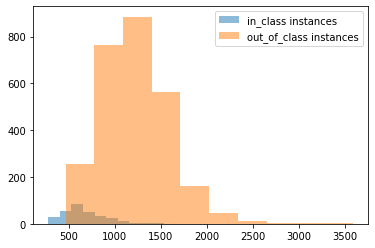

In [19]:
class_index = 0
mask = y_test == class_index
plt.hist(feat_mean_dist[mask,class_index], alpha=0.5)
plt.hist(feat_mean_dist[~mask,class_index], alpha=0.5)
plt.legend(['in_class instances', 'out_of_class instances'])
print('But the distance to the mean does not seem to indicate class seperation ?????')
print('Try different class indexes, the trend holds true.')

In [20]:
auroc_scores = np.zeros(num_class)
for i in range(num_class):
    auroc_scores[i] = roc_auc_score(y_test == i, -feat_mean_dist[:,i])
print('The poor performance of distance based class validation can be verified empirically.')
print('average auroc:', np.mean(auroc_scores))

The poor performance of distance based class validation can be verified empirically.
average auroc: 0.8779491358024691


## Noise cancellation

We hypothesize that noise induces a constant, instance specific offset to distances.
This would mean that the impact of noise can be offset by subtracting the distance from a vector that is indepdent of the underlying generative processes. Ideally, this vector should be as close to the mean of such generative procsses as possible.




     With noise cancellation can be used to validate class membership.
     The dataset mean is used as the reference vector in noise cancellation.
     


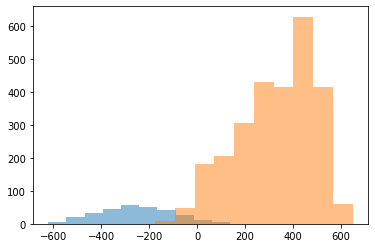

In [21]:
print('''
     With noise cancellation can be used to validate class membership.
     The dataset mean is used as the reference vector in noise cancellation.
     '''
     )
ref_vec = np.mean(x_train, axis=0, keepdims=True)
dis_2_vec = pairwise_distances(x_test, ref_vec) ** 2
noise_canceled_dist = feat_mean_dist - dis_2_vec

mask = y_test == class_index
plt.hist(noise_canceled_dist[mask,class_index], alpha=0.5)
plt.hist(noise_canceled_dist[~mask,class_index], alpha=0.5);



     Reference vector can be a random vector whose mean and magnitude is somewhat similar to current data.
     


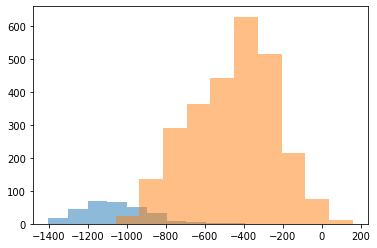

In [22]:
print('''
     Reference vector can be a random vector whose mean and magnitude is somewhat similar to current data.
     '''
     )


average_mag = np.mean(np.linalg.norm(x_train, axis=1))
ref_vec = (np.random.random([1, num_dim])) - 0.5 + np.mean(x_train)
ref_vec = ref_vec * (average_mag / np.mean(np.linalg.norm(ref_vec, axis=1)))

dis_2_vec = pairwise_distances(x_test, ref_vec) ** 2
noise_canceled_dist = feat_mean_dist - dis_2_vec

mask = y_test == class_index
plt.hist(noise_canceled_dist[mask,class_index], alpha=0.5)
plt.hist(noise_canceled_dist[~mask,class_index], alpha=0.5);



     Normalization is a form of noise cancellation.
     


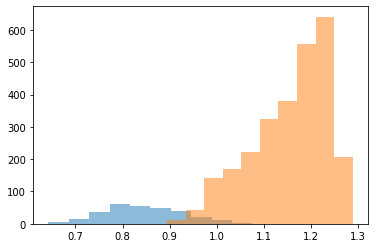

In [23]:
print('''
     Normalization is a form of noise cancellation.
     '''
     )


x_train_norm, norm_vec = normIt(x_train)
x_test_norm, _ = normIt(x_test, norm_vec)
mean_normed = est_class_means(x_train_norm, y_train)
pairwise_distances_normed = pairwise_distances(x_test_norm, mean_normed)

mask = y_test == class_index
plt.hist(pairwise_distances_normed[mask,class_index], alpha=0.5)
plt.hist(pairwise_distances_normed[~mask,class_index], alpha=0.5);



     If a reference vector cannot be estimated, instance normalization can be a solution.
        @article{linlocally,
          title={Locally Varying Distance Transform for Unsupervised Visual Anomaly Detection},
          author={Lin, Wen-Yan and Liu, Zhonghang and Liu, Siying},
          journal={ECCV},
          year={2022}
        }     
    


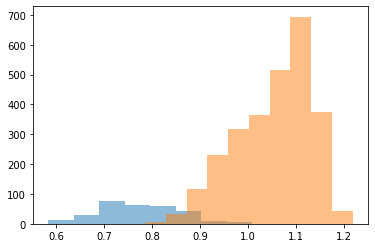

In [24]:
print('''
     If a reference vector cannot be estimated, instance normalization can be a solution.
        @article{linlocally,
          title={Locally Varying Distance Transform for Unsupervised Visual Anomaly Detection},
          author={Lin, Wen-Yan and Liu, Zhonghang and Liu, Siying},
          journal={ECCV},
          year={2022}
        }     
    '''
     )

def instance_norm(data):
    norm_data = data - np.mean(data, axis=1, keepdims=True)
    norm_data = norm_data / np.linalg.norm(norm_data, axis=1, keepdims=True)
    return norm_data

x_train_norm = instance_norm(x_train)
x_test_norm = instance_norm(x_test)


mean_normed = est_class_means(x_train_norm, y_train)
pairwise_distances_normed = pairwise_distances(x_test_norm, mean_normed)

mask = y_test == class_index
plt.hist(pairwise_distances_normed[mask,class_index], alpha=0.5)
plt.hist(pairwise_distances_normed[~mask,class_index], alpha=0.5);
